# Week 4 — Academic Success Predictor (EDM)

You are the teaching team's **lead data scientists**. Using a (synthetic) pre-course survey dataset, you will:

- explore the cohort’s baseline readiness
- engineer meaningful features
- build a predictive model using **PyTorch `nn.Linear`** (regression or classification)
- design a simple **At‑Risk Intervention** alert

**Important**
- This dataset (`student_success_survey.csv`) is **synthetic** and created for learning.
- Do **not** use `student_uid` as a predictive feature (it is an identifier).

---

## Learning goals
- Practice real-world preprocessing: missing values, encoding, scaling
- Build a clean ML pipeline and avoid leakage
- Compare regression vs classification framing
- Interpret linear model weights and discuss limitations
- Translate predictions into actionable interventions (ethics-aware)


## 0) Setup & reproducibility

Run this cell first. If you are using **Google Colab**, you usually already have `pandas`, `sklearn`, and `torch` installed.


In [1]:
import sys
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cpu


## 1) Load the dataset

Place `student_success_survey.csv` in the same folder as this notebook.

**Colab tip**: upload the CSV from your computer.


In [2]:
# If you're in Colab, uncomment this:
# from google.colab import files
# files.upload()  # select student_success_survey.csv

DATA_PATH = "student_success_survey.csv"  # adjust if needed

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(240, 25)


,student_uid,pillar,current_term,cgpa,prereq_ct_grade,used_pytorch_tensorflow,used_big_data_tools,diag_python_mod_answer,diag_pvalue_answer,diag_pca_answer,...,grit_i_finish_what_i_begin,cse_debug_python_without_help,cse_learn_new_ml_library,cse_explain_model_theory,cse_interpret_complex_viz,hours_per_week_planned,commute_minutes_daily,team_formed_for_final_project,laptop_or_cloud_ready,final_course_score
0,STU_001,ASD,Term 7,4.62,A/A+,Yes,No,Error,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,4,3,5,3,3,7.0,21.0,Yes,Yes,83.0
1,STU_002,ASD,Term 6,4.00,A-,No,Yes,2,Statistically significant (reject H0),Integration by parts,...,3,4,3,3,4,6.0,63.0,No,Yes,65.9
2,STU_003,ASD,Term 6,4.13,B+,No,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,1,5,4,4,5,8.0,60.0,Yes,Yes,80.3
3,STU_004,ISTD,Term 6,4.69,A/A+,Yes,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,3,3,4,3,2,3.0,31.0,Yes,Yes,71.1
4,STU_005,ISTD,Term 7,4.63,A/A+,Yes,No,0.66,96% probability H0 is true,Finding eigenvalues and eigenvectors,...,2,4,4,4,5,7.0,15.0,Yes,Yes,68.2


### Quick sanity checks

✅ You should see ~200+ rows and ~20–30 columns.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   student_uid                          240 non-null    object 
 1   pillar                               240 non-null    object 
 2   current_term                         240 non-null    object 
 3   cgpa                                 231 non-null    float64
 4   prereq_ct_grade                      240 non-null    object 
 5   used_pytorch_tensorflow              240 non-null    object 
 6   used_big_data_tools                  240 non-null    object 
 7   diag_python_mod_answer               240 non-null    object 
 8   diag_pvalue_answer                   240 non-null    object 
 9   diag_pca_answer                      240 non-null    object 
 10  grit_distracted_by_new_ideas         240 non-null    int64  
 11  grit_setbacks_dont_discourage_me

In [4]:
# Missing values per column
(df.isna().mean().sort_values(ascending=False) * 100).round(1).head(10)


commute_minutes_daily            6.2
cgpa                             3.8
hours_per_week_planned           3.3
student_uid                      0.0
grit_i_am_a_hard_worker          0.0
laptop_or_cloud_ready            0.0
team_formed_for_final_project    0.0
cse_interpret_complex_viz        0.0
cse_explain_model_theory         0.0
cse_learn_new_ml_library         0.0
dtype: float64

## 2) Understand the features (data dictionary)

The dataset is derived from the course survey form. Key groups:

- **Academic background**: `pillar`, `current_term`, `cgpa`, `prereq_ct_grade`
- **Experience**: `used_pytorch_tensorflow`, `used_big_data_tools`
- **Diagnostic** (multiple-choice): `diag_*_answer`
- **Grit (Likert 1–5)**: `grit_*`
- **Self‑efficacy (Likert 1–5)**: `cse_*`
- **Logistics**: `hours_per_week_planned`, `commute_minutes_daily`, `team_*`, `laptop_*`

**Target variable**
- `final_course_score` (0–100): a synthetic proxy for final performance.

---

### Your first decision (Task 1): Regression or Classification?
Pick one:

- **A. Regression**: predict `final_course_score` directly.
- **B. Classification**: predict a binary label (e.g. **Distinction** vs **Non‑Distinction**).

You will implement the model as **one linear layer** using PyTorch: `nn.Linear`.


## Regression, code is at Regession(Task1)/pytorch_regression.py, code below will import all function/ classes from folder structure

In [5]:
folders_to_import = [
    'feature_engineer(task3)',
    'Regression(Task1)',
    "intervention_alert(task5)"
    
]

for folder in folders_to_import:
    folder_path = os.path.abspath(folder)
    if folder_path not in sys.path:
        sys.path.append(folder_path)

from feature_engineer import *


## 3) Feature engineering (scaffold)

Create at least **two engineered features**.

Suggested ideas:
1. **Grit score**: average the grit items **with reverse‑coding where appropriate**.
2. **Technical readiness**: combine diagnostic correctness + experience.
3. **Time budget score**: e.g., `hours_per_week_planned - commute_minutes_daily/60`.

⚠️ Reverse-coded grit items in this dataset:
- `grit_distracted_by_new_ideas`
- `grit_short_term_obsession_then_loss`
- `grit_i_change_goals`

Reverse-coding rule for a 1–5 scale: `reversed = 6 - original`.


In [6]:
# TODO: Engineer at least TWO features.

GRIT_POS = [
    "grit_setbacks_dont_discourage_me",
    "grit_i_am_a_hard_worker",
    "grit_i_finish_what_i_begin",
]

GRIT_NEG = [
    "grit_distracted_by_new_ideas",
    "grit_short_term_obsession_then_loss",
    "grit_i_change_goals",
]

# Reverse-code the negative items
for col in GRIT_NEG:
    df[col + "_rev"] = 6 - df[col]

# Example engineered feature 1: average grit
df["avg_grit"] = df[GRIT_POS + [c + "_rev" for c in GRIT_NEG]].mean(axis=1)

# TODO: engineered feature 2 (pick one idea above)
# df["tech_readiness"] = ...

# Quick check
df[["avg_grit"]].describe().T


,count,mean,std,min,25%,50%,75%,max
avg_grit,240.0,2.970833,0.822217,1.0,2.333333,3.0,3.5,5.0


In [7]:
final_df = run_full_pipeline(df)

In [8]:
final_df

,student_uid,pillar,current_term,cgpa,prereq_ct_grade,used_pytorch_tensorflow,used_big_data_tools,diag_python_mod_answer,diag_pvalue_answer,diag_pca_answer,...,total_grit_score,matches_best_diag_python_mod_answer,matches_best_diag_pvalue_answer,matches_best_diag_pca_answer,hidden_knowledge_score,python_confidence_gap,weekly_commute_hours,study_friction_index,student_year,pillar_year
0,STU_001,ASD,Term 7,4.62,A/A+,Yes,No,Error,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,3.500000,0,1,1,2,3.0000,1.750000,0.218750,final year,ASD final year
1,STU_002,ASD,Term 6,4.00,A-,No,Yes,2,Statistically significant (reject H0),Integration by parts,...,2.666667,1,1,0,2,0.6800,5.250000,0.750000,3rd year student,ASD 3rd year student
2,STU_003,ASD,Term 6,4.13,B+,No,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,2.666667,1,1,1,3,1.6800,5.000000,0.555556,3rd year student,ASD 3rd year student
3,STU_004,ISTD,Term 6,4.69,A/A+,Yes,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,2.000000,1,1,1,3,-0.3200,2.583333,0.645833,3rd year student,ISTD 3rd year student
4,STU_005,ISTD,Term 7,4.63,A/A+,Yes,No,0.66,96% probability H0 is true,Finding eigenvalues and eigenvectors,...,3.166667,0,0,1,1,2.9044,1.250000,0.156250,final year,ISTD final year
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,STU_236,ESD,Term 8,3.92,B,No,No,Error,96% probability H0 is true,Integration by parts,...,3.333333,0,0,0,0,2.0000,3.000000,0.250000,final year,ESD final year
236,STU_237,DAI,Term 6,4.17,B+,Yes,No,Error,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,1.833333,0,1,1,2,3.0000,6.166667,1.027778,3rd year student,DAI 3rd year student
237,STU_238,ISTD,Term 7,3.78,A/A+,No,Yes,0,96% probability H0 is true,Finding eigenvalues and eigenvectors,...,2.166667,0,0,1,1,1.0000,2.916667,0.324074,final year,ISTD final year
238,STU_239,ISTD,Term 7,3.74,A/A+,Yes,No,2,Statistically significant (reject H0),Calculating the derivative,...,2.666667,1,1,0,2,-1.3200,0.750000,0.125000,final year,ISTD final year


## 4) Exploratory Data Analysis (EDA)

Answer these questions with visuals + 2–4 sentences each:

1. Does **grit** correlate with **planned hours per week**?
2. Is **CGPA** roughly linearly related to **final_course_score**?
3. Are there obvious group differences by `pillar`?

Tip: keep plots readable; label axes; include titles.


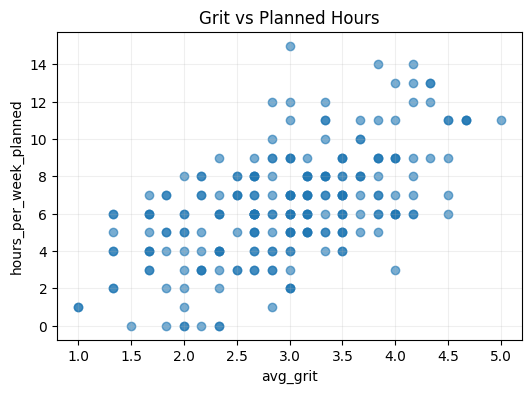

In [9]:
# 4.1 Grit vs hours
plt.figure(figsize=(6, 4))
plt.scatter(df["avg_grit"], df["hours_per_week_planned"], alpha=0.6)
plt.xlabel("avg_grit")
plt.ylabel("hours_per_week_planned")
plt.title("Grit vs Planned Hours")
plt.grid(True, alpha=0.2)
plt.show()


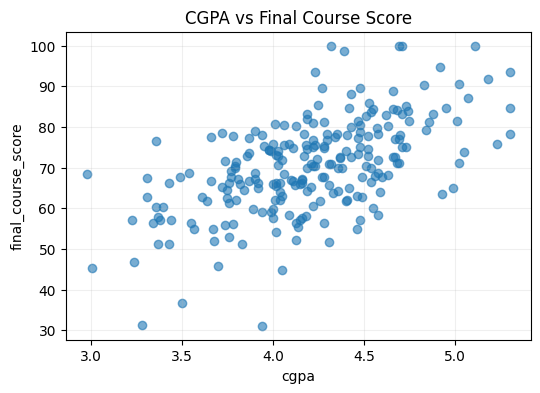

In [10]:
# 4.2 CGPA vs final score
plt.figure(figsize=(6, 4))
plt.scatter(df["cgpa"], df["final_course_score"], alpha=0.6)
plt.xlabel("cgpa")
plt.ylabel("final_course_score")
plt.title("CGPA vs Final Course Score")
plt.grid(True, alpha=0.2)
plt.show()


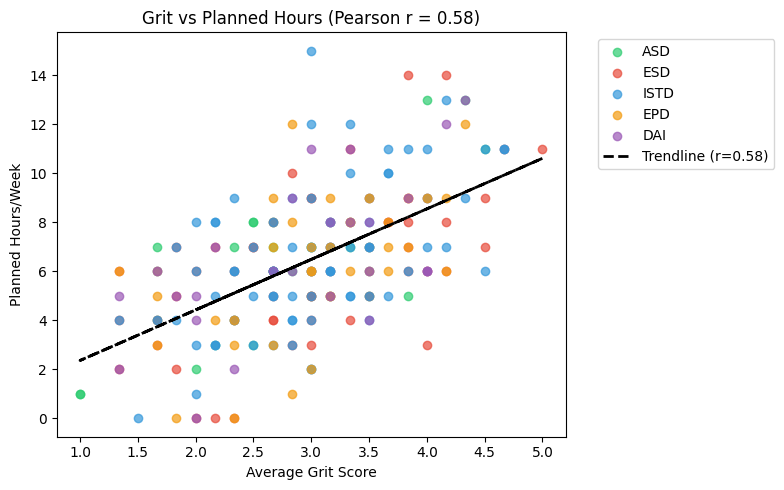

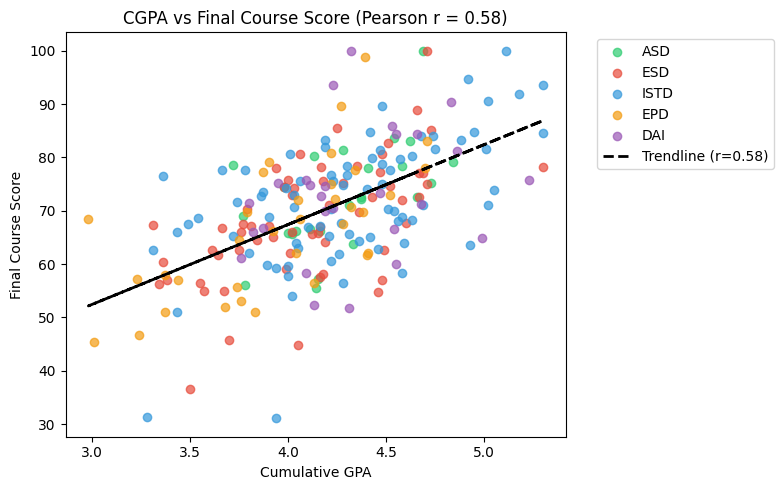

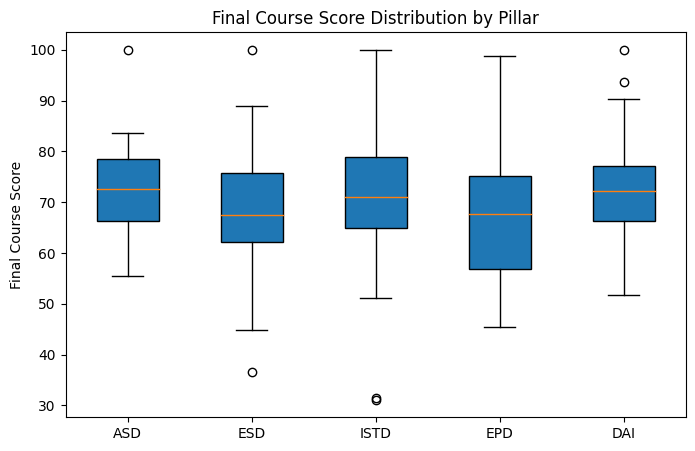

In [11]:
from scipy.stats import pearsonr

# 1. Define Pillar Colors for consistency
PILLAR_COLORS = {
    'ASD': '#2ecc71', # Green
    'ESD': '#e74c3c', # Red
    'ISTD': '#3498db', # Blue
    'EPD': '#f39c12', # Orange
    'DAI': '#9b59b6'  # Purple
}
pillars = ['ASD', 'ESD', 'ISTD', 'EPD', 'DAI']

def plot_with_regression(df, x_col, y_col, title, x_label, y_label):
    # Clean data (remove rows with NaNs in either column)
    clean_df = df[[x_col, y_col, 'pillar']].dropna()
    
    plt.figure(figsize=(8, 5))
    
    # Calculate Pearson Correlation (r value)
    r_val, _ = pearsonr(clean_df[x_col], clean_df[y_col])
    
    # 1. Plot scatter points differentiated by pillar
    for p in pillars:
        subset = clean_df[clean_df['pillar'] == p]
        plt.scatter(subset[x_col], subset[y_col], 
                    label=p, color=PILLAR_COLORS.get(p, 'grey'), alpha=0.7)
    
    # 2. Add Linear Regression line (Trendline)
    # y = mx + c
    m, c = np.polyfit(clean_df[x_col], clean_df[y_col], 1)
    plt.plot(clean_df[x_col], m * clean_df[x_col] + c, color='black', 
             linestyle='--', linewidth=2, label=f'Trendline (r={r_val:.2f})')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{title} (Pearson r = {r_val:.2f})")
    plt.grid(False) # Remove gridlines for a clean look
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- Execution ---

# 4.1 Grit vs hours
plot_with_regression(df, "avg_grit", "hours_per_week_planned", 
                     "Grit vs Planned Hours", "Average Grit Score", "Planned Hours/Week")

# 4.2 CGPA vs final score
plot_with_regression(df, "cgpa", "final_course_score", 
                     "CGPA vs Final Course Score", "Cumulative GPA", "Final Course Score")

# 4.3 Group Differences by Pillar (Boxplot for clear group comparison)
plt.figure(figsize=(8, 5))
box_data = [df[df['pillar'] == p]['final_course_score'].dropna() for p in pillars]
plt.boxplot(box_data, labels=pillars, patch_artist=True)
plt.title("Final Course Score Distribution by Pillar")
plt.ylabel("Final Course Score")
plt.grid(False)
plt.show()

## 5) Preprocessing (no leakage)

We will:
- split into train/test
- impute missing values
- standardize numeric features
- one-hot encode categorical features

✅ This produces a single numeric design matrix that you can feed into `nn.Linear`.


In [12]:
TARGET = "final_course_score"

# Define your feature set (edit this!)
NUMERIC_FEATURES = [
    "cgpa",
    "hours_per_week_planned",
    "commute_minutes_daily",
    "avg_grit",
    # TODO: add your engineered features here
    "total_grit_score",
    'hidden_knowledge_score',
      'study_friction_index', 
      'is_logistics_missing', 
      'python_confidence_gap' 
        
]

CATEGORICAL_FEATURES = [
    "pillar",
    "current_term",
    "prereq_ct_grade",
    "used_pytorch_tensorflow",
    "used_big_data_tools",
    "diag_python_mod_answer",
    "diag_pvalue_answer",
    "diag_pca_answer",
    "team_formed_for_final_project",
    "laptop_or_cloud_ready",
    'pillar_year'
]

feature_cols = NUMERIC_FEATURES + CATEGORICAL_FEATURES

X = final_df[feature_cols].copy()
y = final_df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# scikit-learn changed this arg name; support both.
try:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", onehot),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC_FEATURES),
        ("cat", categorical_pipe, CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

X_train_np = preprocess.fit_transform(X_train)
X_test_np = preprocess.transform(X_test)

print("X_train shape:", X_train_np.shape)
print("X_test shape:", X_test_np.shape)


X_train shape: (192, 58)
X_test shape: (48, 58)


## 6) Modeling with PyTorch `nn.Linear`

You will implement a **single-layer linear model**.

### Option A — Regression (MSE)
- loss: `nn.MSELoss()`
- metrics: MSE, R²

### Option B — Classification (BCEWithLogits)
- create a binary target label (e.g. distinction = score ≥ threshold)
- loss: `nn.BCEWithLogitsLoss()`
- metrics: confusion matrix, precision, recall, F1

---

### Starter: model + training loop (works for regression)


In [13]:
class StudentSuccessLinear(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)


def make_loaders(X_train_np, y_train_np, X_test_np, y_test_np, batch_size=32):
    X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)

    train_loader = DataLoader(
        TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader


def train_regression(model, train_loader, test_loader, epochs=300, lr=1e-2):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)

        train_losses.append(epoch_loss / len(train_loader.dataset))

        # eval
        model.eval()
        with torch.no_grad():
            total = 0.0
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                pred = model(xb)
                loss = criterion(pred, yb)
                total += loss.item() * xb.size(0)
            test_losses.append(total / len(test_loader.dataset))

        if epoch % 50 == 0:
            print(f"Epoch {epoch:4d} | train MSE {train_losses[-1]:.3f} | test MSE {test_losses[-1]:.3f}")

    return train_losses, test_losses


Epoch   50 | train MSE 1714.266 | test MSE 1512.252
Epoch  100 | train MSE 437.379 | test MSE 354.253
Epoch  150 | train MSE 114.639 | test MSE 78.980
Epoch  200 | train MSE 61.966 | test MSE 43.338
Epoch  250 | train MSE 54.864 | test MSE 43.193
Epoch  300 | train MSE 52.421 | test MSE 45.078


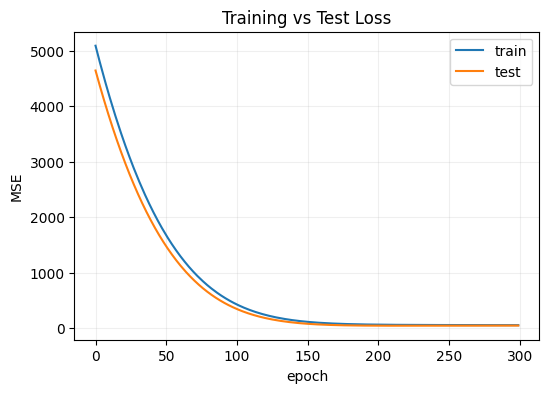

In [14]:
# Baseline: regression model

train_loader, test_loader = make_loaders(
    X_train_np,
    y_train.to_numpy(),
    X_test_np,
    y_test.to_numpy(),
    batch_size=32,
)

model = StudentSuccessLinear(input_dim=X_train_np.shape[1])
train_losses, test_losses = train_regression(model, train_loader, test_loader, epochs=300, lr=1e-2)

# Plot loss curves
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


In [15]:
# Evaluate regression (MSE, R^2)

model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32).to(DEVICE)
    preds = model(X_test_t).cpu().numpy().reshape(-1)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("Test MSE:", round(mse, 3))
print("Test R2:", round(r2, 3))


Test MSE: 45.078
Test R2: 0.491


## 7) Your turn: improve the model

Minimum requirements:
- Add **≥2 engineered features**
- Justify features with EDA
- Train either:
  - regression, or
  - classification (you must pick a label definition + threshold)

Stretch goals:
- try L2 regularization (`weight_decay`)
- compare regression vs classification framing
- interpret weights: which features help/hurt predicted success?

---

### Optional: classification scaffold


In [16]:
final_df2 = select_final_features(final_df)

In [17]:
final_df2

,cgpa,is_cgpa_missing,prereq_ct_grade,used_pytorch_tensorflow,laptop_or_cloud_ready,total_grit_score,hidden_knowledge_score,study_friction_index,is_logistics_missing,python_confidence_gap,pillar_year,final_course_score
0,4.62,0,A/A+,Yes,Yes,3.500000,2,0.218750,0,3.0000,ASD final year,83.0
1,4.00,0,A-,No,Yes,2.666667,2,0.750000,0,0.6800,ASD 3rd year student,65.9
2,4.13,0,B+,No,Yes,2.666667,3,0.555556,0,1.6800,ASD 3rd year student,80.3
3,4.69,0,A/A+,Yes,Yes,2.000000,3,0.645833,0,-0.3200,ISTD 3rd year student,71.1
4,4.63,0,A/A+,Yes,Yes,3.166667,1,0.156250,0,2.9044,ISTD final year,68.2
...,...,...,...,...,...,...,...,...,...,...,...,...
235,3.92,0,B,No,Yes,3.333333,0,0.250000,1,2.0000,ESD final year,65.1
236,4.17,0,B+,Yes,Yes,1.833333,2,1.027778,0,3.0000,DAI 3rd year student,72.8
237,3.78,0,A/A+,No,Yes,2.166667,1,0.324074,0,1.0000,ISTD final year,77.7
238,3.74,0,A/A+,Yes,Yes,2.666667,2,0.125000,0,-1.3200,ISTD final year,71.7


In [18]:
from pytorch_regression import prepare_data

X_2, y_2  = prepare_data(final_df2)


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2, y_2, test_size=0.2, random_state=SEED
)

# X_train_scaled_2 = scaler.fit_transform(X_train)
# X_test_scaled_2 = scaler.transform(X_test)


In [19]:
X_train_2

,cgpa,prereq_ct_grade_encoded,used_pytorch_tensorflow_enc,laptop_or_cloud_ready_enc,total_grit_score,hidden_knowledge_score,study_friction_index,python_confidence_gap,pillar_year_ASD 3rd year student,pillar_year_ASD final year,pillar_year_DAI 3rd year student,pillar_year_DAI final year,pillar_year_EPD 3rd year student,pillar_year_EPD final year,pillar_year_ESD 3rd year student,pillar_year_ESD final year,pillar_year_ISTD 3rd year student,pillar_year_ISTD final year,pillar_year_Other 3rd year student,pillar_year_Other final year
139,4.71,5.0,1,1,3.333333,2,0.428571,0.34,False,False,False,False,True,False,False,False,False,False,False,False
60,4.23,5.0,1,1,4.166667,2,0.282051,1.68,False,False,False,True,False,False,False,False,False,False,False,False
204,3.86,4.0,0,1,2.833333,1,0.270833,3.00,False,False,False,False,False,False,False,False,True,False,False,False
186,4.46,4.5,0,0,3.500000,0,0.266667,3.34,False,False,False,False,False,False,False,False,False,True,False,False
207,3.55,3.5,0,0,3.166667,1,0.375000,1.34,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,4.11,4.0,1,1,1.666667,2,0.500000,0.68,True,False,False,False,False,False,False,False,False,False,False,False
14,4.32,5.0,0,1,2.333333,1,1.500000,-0.32,False,False,False,False,False,True,False,False,False,False,False,False
92,3.31,2.7,1,1,3.500000,2,0.773810,-0.32,False,False,False,False,False,False,True,False,False,False,False,False
179,4.68,5.0,1,1,3.666667,2,0.166667,-1.32,False,False,False,False,False,False,False,False,True,False,False,False


Epoch   50 | train MSE 4708.289 | test MSE 4455.875
Epoch  100 | train MSE 4302.829 | test MSE 4129.465
Epoch  150 | train MSE 3931.235 | test MSE 3802.283
Epoch  200 | train MSE 3585.986 | test MSE 3482.651
Epoch  250 | train MSE 3263.761 | test MSE 3174.241
Epoch  300 | train MSE 2961.864 | test MSE 2882.034
Epoch  350 | train MSE 2679.815 | test MSE 2607.698
Epoch  400 | train MSE 2415.795 | test MSE 2348.000
Epoch  450 | train MSE 2169.624 | test MSE 2106.351
Epoch  500 | train MSE 1940.291 | test MSE 1880.783
Epoch  550 | train MSE 1727.176 | test MSE 1671.240
Epoch  600 | train MSE 1529.620 | test MSE 1476.743
Epoch  650 | train MSE 1347.178 | test MSE 1297.187
Epoch  700 | train MSE 1179.427 | test MSE 1132.129
Epoch  750 | train MSE 1025.788 | test MSE 981.867
Epoch  800 | train MSE 885.754 | test MSE 843.722
Epoch  850 | train MSE 759.086 | test MSE 719.863
Epoch  900 | train MSE 645.308 | test MSE 608.269
Epoch  950 | train MSE 543.852 | test MSE 508.844
Epoch 1000 | train MS

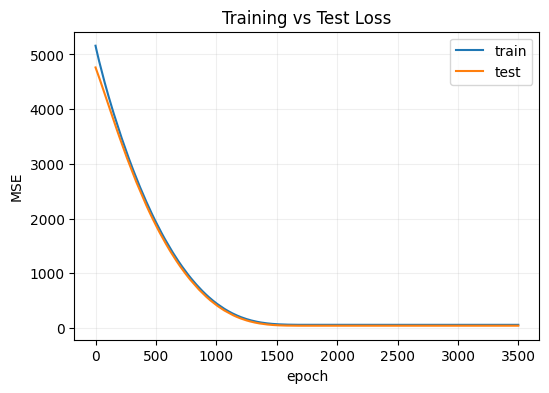

In [20]:
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2.to_numpy())
X_test_scaled_2 = scaler.transform(X_test_2.to_numpy())

train_loader_2, test_loader_2 = make_loaders(
    X_train_scaled_2,
    y_train_2.to_numpy(),
    X_test_scaled_2,
    y_test_2.to_numpy(),
    batch_size=32,
)

model = StudentSuccessLinear(input_dim=X_train_2.shape[1])
train_losses, test_losses = train_regression(model, train_loader_2, test_loader_2, epochs=3500, lr=1e-2)

# Plot loss curves
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


In [21]:
# Evaluate regression (MSE, R^2)

model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_scaled_2, dtype=torch.float32).to(DEVICE)
    preds = model(X_test_t).cpu().numpy().reshape(-1)

mse = mean_squared_error(y_test_2, preds)
r2 = r2_score(y_test_2, preds)
print("Test MSE:", round(mse, 3))
print("Test R2:", round(r2, 3))


Test MSE: 43.002
Test R2: 0.515


In [22]:
# # OPTIONAL (Classification)
# # Define a binary label. Example: distinction if score >= 85.

# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# DISTINCTION_THRESHOLD = 80  # TODO: try different thresholds

# y_bin = (df["final_course_score"] >= DISTINCTION_THRESHOLD).astype(int)
# print("Positive rate (label=1):", float(y_bin.mean()))


# X_train, X_test, y_train, y_test = train_test_split(
#     df[feature_cols], y_bin, test_size=0.2, random_state=SEED, stratify=y_bin
# )

# X_train_np = preprocess.fit_transform(X_train)
# X_test_np = preprocess.transform(X_test)

# train_loader, test_loader = make_loaders(
#     X_train_np,
#     y_train.to_numpy(),
#     X_test_np,
#     y_test.to_numpy(),
#     batch_size=32,
# )

# model = StudentSuccessLinear(input_dim=X_train_np.shape[1]).to(DEVICE)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-2)

# EPOCHS = 300
# for epoch in range(1, EPOCHS + 1):
#     model.train()
#     for xb, yb in train_loader:
#         xb = xb.to(DEVICE)
#         yb = yb.to(DEVICE)

#         logits = model(xb)
#         loss = criterion(logits, yb)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     if epoch % 50 == 0:
#         print("epoch", epoch, "loss", float(loss))

# # Evaluate
# model.eval()
# with torch.no_grad():
#     X_test_t = torch.tensor(X_test_np, dtype=torch.float32).to(DEVICE)
#     logits = model(X_test_t).cpu().numpy().reshape(-1)

# probs = 1 / (1 + np.exp(-logits))
# THRESHOLD = 0.5
# preds = (probs >= THRESHOLD).astype(int)

# cm = confusion_matrix(y_test, preds)
# print("Confusion matrix:
# ", cm)
# print("Precision:", precision_score(y_test, preds))
# print("Recall:", recall_score(y_test, preds))
# print("F1:", f1_score(y_test, preds))

# # TODO: Tune THRESHOLD for higher Recall (why might that matter for at-risk alerts?)


## 8) PCA: do students cluster by academic pillar?

Use PCA on the **preprocessed design matrix** and visualize the first 2 components.

Prompt:
- Do you see clusters? If not, why might that be?
- What does PCA *not* tell you?


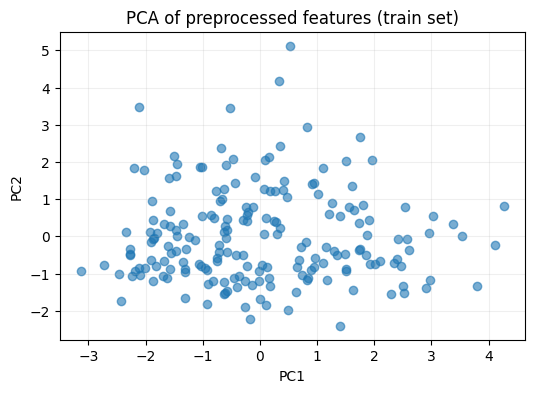

Explained variance ratio: [0.11808304 0.07789835]


In [23]:
from sklearn.decomposition import PCA

# Fit PCA on the TRAIN matrix (no leakage)
pca = PCA(n_components=2, random_state=SEED)
Z = pca.fit_transform(X_train_scaled_2)

plt.figure(figsize=(6, 4))
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.6)
plt.title("PCA of preprocessed features (train set)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.2)
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[-5.27620800e-01 -5.07496702e-01 -2.88376799e-01 -1.54476442e-01
  -2.42239528e-02 -4.13267958e-01  4.08399803e-02  1.35052271e-01
   3.16347334e-02 -1.76683391e-01  1.07579062e-02 -9.12968567e-02
   2.17677551e-01  1.51489063e-01  3.04263599e-02  1.37362684e-01
  -7.47979715e-02 -1.69767749e-01 -1.13326461e-02 -2.03816569e-02]
 [ 5.03648744e-02  2.28312870e-02  1.03044339e-01 -9.07872416e-02
  -6.18232377e-01  6.49980049e-02  4.98898207e-01  6.29994170e-02
   2.53650496e-01 -8.93642865e-02  1.91771833e-01 -1.73253120e-01
  -4.80062092e-02  3.68716442e-02 -4.19996010e-02 -1.38758266e-01
   3.16077234e-01 -2.59838517e-01 -7.36171910e-02  4.62316245e-02]
 [ 2.66800821e-01  1.60863161e-01 -1.52081736e-01 -3.78531117e-01
   2.32991952e-03 -2.17305518e-01 -1.37206185e-01  5.26215630e-01
  -7.02100910e-02  1.14460716e-01  2.32952791e-01  2.14658525e-01
   2.34796950e-01 -2.47003910e-01 -1.34260171e-01 -1.11960390e-01
  -2.88115792e-02 -7.99534777e-02 -1.06207584e-01  3.31647380e-01]
 [ 5.55

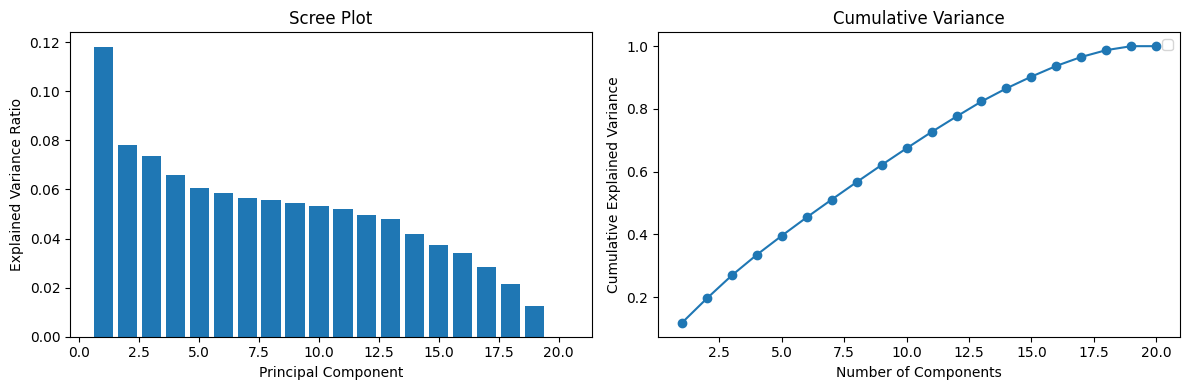

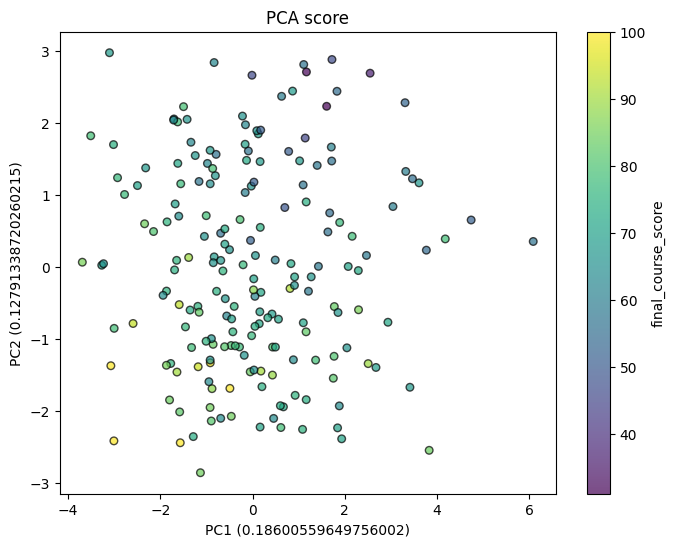

PC1 + PC2 explain 0.31391898370016214 of total variance


In [24]:
# fit on train to prevent leak
pca_full = PCA(random_state=SEED)
pca_full.fit(X_train_scaled_2)
print(pca_full.components_)
# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), pca_full.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
cumulative = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, len(cumulative) + 1), cumulative, 'o-')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance')
axes[1].legend()
plt.tight_layout()
plt.show()

# scatter 
pca_2d = PCA(n_components=2, random_state=SEED)
Z = pca_2d.fit_transform(X_train_np)

plt.figure(figsize=(8, 6))
sc = plt.scatter(Z[:, 0], Z[:, 1], c=y_train.values, alpha=0.7, s=30, edgecolors='k')
plt.colorbar(sc, label='final_course_score')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]})')
plt.title('PCA score')
plt.show()

print(f"PC1 + PC2 explain {pca_2d.explained_variance_ratio_.sum()} of total variance")

## 9) The “At‑Risk Intervention Alert” (agentic add‑on)

In educational data mining, prediction is only useful if it leads to **action**.

Design a function that:
- identifies at-risk students
- outputs a **pedagogical recommendation** (specific + actionable)

Examples of recommendations:
- “Review Python basics: `2 % 3`, loops, lists”
- “Attend Week 1–2 recap clinic”
- “Form a project team early + schedule 2h/week study block”

⚠️ Ethics: the alert should be supportive, not punitive.


In [25]:
def recommend_intervention(row, predicted_score=None, threshold=70):
    '''Return (risk_level, recommendation).

    TODO: tune rules based on your EDA + model.
    '''

    # Example rule-based scaffold
    if predicted_score is not None and predicted_score < threshold:
        # Customize these rules
        if row.get("hours_per_week_planned") is not None and row.get("hours_per_week_planned") < 5:
            return "high", "Increase weekly study plan to 6–8h; block it on your calendar."
        if row.get("cgpa") is not None and row.get("cgpa") < 3.5:
            return "high", "Book a consult with TA; focus on foundations + weekly practice."
        return "medium", "Do the Week 1–2 refresher worksheet + attend office hours."

    return "low", "Keep up the good work; consider helping peers or taking stretch tasks."


# Demo on one row (replace `predicted_score` with your model output)
example = df.iloc[0].to_dict()
recommend_intervention(example, predicted_score=65)


('medium', 'Do the Week 1–2 refresher worksheet + attend office hours.')

In [27]:
from get_at_risk import * 

get_at_risk_students(final_df2, predicted_score=65)

filtered


,cgpa,is_cgpa_missing,prereq_ct_grade,used_pytorch_tensorflow,laptop_or_cloud_ready,total_grit_score,hidden_knowledge_score,study_friction_index,is_logistics_missing,python_confidence_gap,pillar_year,final_course_score,recommendation
5,4.05,0,B,Yes,Yes,3.000000,0,1.437500,0,1.9044,ESD final year,44.9,You may want to have more consistent practice ...
15,4.01,0,A-,No,No,3.833333,1,0.157407,0,4.0000,ESD final year,62.1,You may want to
16,3.94,0,B+,No,Yes,3.500000,1,0.736111,0,0.3400,ISTD final year,59.2,You may want to have more consistent practice ...
19,3.38,0,B-,Yes,Yes,2.500000,0,0.375000,1,3.9044,ESD final year,57.0,You may want to have more consistent practice ...
20,4.02,0,A-,No,Yes,1.500000,1,2.083333,0,-1.3200,ISTD final year,54.1,You may want to consider additional mentoring ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,4.31,0,A/A+,No,Yes,2.000000,1,4.500000,0,2.0000,DAI 3rd year student,51.7,You may want to consider additional mentoring ...
227,4.13,0,B+,No,Yes,2.000000,0,0.611111,0,3.0000,DAI 3rd year student,52.3,You may want to consider additional mentoring ...
228,3.64,0,B,No,Yes,3.333333,1,0.654762,1,2.3400,ESD 3rd year student,61.7,You may want to have more consistent practice ...
230,4.41,0,A/A+,No,Yes,1.666667,1,0.305556,0,3.0000,EPD final year,62.0,You may want to consider additional mentoring ...


## Submission checklist

Your notebook should:
- run end-to-end without errors
- include clear plots + short written interpretation
- include feature engineering + justification
- include a PyTorch `nn.Linear` model with training loop
- include evaluation metrics + a short discussion of limitations
- include the at-risk intervention function + ethical reflection

---

### Reflection prompts (write 3–6 sentences)
- What would make this model *unsafe* to deploy in real life?
- Which student groups might be disadvantaged by these features?
- What additional data would you want, and why?
